典型的卷积算法-Lenet5的实践—猫狗分类

## 库的导入

In [1]:
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile#文件的复制库

## 数据的准备

https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
下载下来的数据存在了F盘，有Cat和Dog两个文件夹。

In [12]:
#输出下载的数据集里面的猫和狗的图片数量
print(len(os.listdir('F:google_download/dogs_and_cats/Cat')))
print(len(os.listdir('F:google_download/dogs_and_cats/Cat')))

12501
12501


In [18]:
#我们需要将数据分为训练集和测试集，所以在F盘建立文件夹【dogs-vs-cats】，该文件夹下有:【train】和【test】两个文件夹;
#【train】下面有个【dogs】和【cats】文件夹
#【test】下面有个【dogs】和【cats】两个文件夹
try:
    os.mkdir('F:google_download/cats-v-dogs')
    os.mkdir('F:google_download/cats-v-dogs/training')
    os.mkdir('F:google_download/cats-v-dogs/testing')
    os.mkdir('F:google_download/cats-v-dogs/training/dogs')
    os.mkdir('F:google_download/cats-v-dogs/training/cats')
    os.mkdir('F:google_download/cats-v-dogs/testing/dogs')
    os.mkdir('F:google_download/cats-v-dogs/testing/cats')
except OSError:
    pass

In [33]:
import os
import shutil
import random
#对数据分割，分割为训练集和测试集,本文训练集占90%
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    #source是
    files = []#装的是所有有效照片的文件地址
    #for循环用来读取图片的文件名
    for filename in os.listdir(SOURCE):
        #filename是图片的名字（eg:'0.jpg'）
        file = SOURCE + filename
        #file是【"F:google_download/dogs_and_cats/Cat/0.jpg"】或者【"F:google_download/dogs_and_cats/Dog/0.jpg"】
        if os.path.getsize(file) > 0:
            #判断这个图片的尺寸是否为1，是的话就就把!!!【0.jpg】!!!放入files列表
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")
            #0长度的图片，需要忽略掉

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))#随机打乱files数组，然后前90%是训练集，后10%是测试集
    #random.sample()方法返回一个列表，其中包含从序列中随机选择的指定数量的项目
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:#对训练集数据分配到猫和狗【training_set是图片的地址】
        this_file = SOURCE + filename#this_file是【"F:google_download/dogs_and_cats/Cat/0.jpg"】
        destination = TRAINING + filename
        # destination是把this_file的图片复制到哪个位置
        copyfile(this_file, destination)#文件复制函数

    for filename in testing_set:#对测试集数据分配到猫和狗
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "F:google_download/dogs_and_cats/Cat/"#最后一个'/'不要的话就进不去Cat下面，要了的话才进得去
TRAINING_CATS_DIR = "F:google_download/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "F:google_download/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "F:google_download/dogs_and_cats/Dog/"
TRAINING_DOGS_DIR = "F:google_download/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "F:google_download/cats-v-dogs/testing/dogs/"


#检查训练集和测试集共计四个子文件夹是否创建成功
def create_dir(file_dir):
    if os.path.exists(file_dir):
        print('true')
        #os.rmdir(file_dir)
        shutil.rmtree(file_dir)#删除再建立
        os.makedirs(file_dir)
    else:
        os.makedirs(file_dir)

create_dir(TRAINING_CATS_DIR)
create_dir(TESTING_CATS_DIR)
create_dir(TRAINING_DOGS_DIR)
create_dir(TESTING_CATS_DIR)
    
split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)


true
true
true
true
666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [2]:
print('训练集中猫的个数：',len(os.listdir('F:google_download/cats-v-dogs/training/cats/')))
print('训练集中狗的个数：',len(os.listdir('F:google_download/cats-v-dogs/training/dogs/')))
print('测试集中猫的个数：',len(os.listdir('F:google_download/cats-v-dogs/testing/cats/')))
print('测试集中狗的个数：',len(os.listdir('F:google_download/cats-v-dogs/testing/dogs/')))


训练集中猫的个数： 11250
训练集中狗的个数： 11250
测试集中猫的个数： 1250
测试集中狗的个数： 1250


## 模型的搭建

In [3]:
#使用的lenet-5的结构
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.optimizers.RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])


In [4]:
#数据的预处理
TRAINING_DIR = "F:google_download/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "F:google_download/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))



Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## 模型的训练

In [5]:
history = model.fit_generator(train_generator,
                              epochs=20,
                              verbose=2,
                              validation_data=validation_generator)

Epoch 1/20


D:\Anaconda\Anaconda\envs\mytf_1\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 - 87s - loss: 0.6682 - acc: 0.6565 - val_loss: 0.5338 - val_acc: 0.7244
Epoch 2/20


D:\Anaconda\Anaconda\envs\mytf_1\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 - 83s - loss: 0.4927 - acc: 0.7582 - val_loss: 0.5004 - val_acc: 0.7564
Epoch 3/20


D:\Anaconda\Anaconda\envs\mytf_1\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 - 83s - loss: 0.4264 - acc: 0.8031 - val_loss: 0.4710 - val_acc: 0.7756
Epoch 4/20


D:\Anaconda\Anaconda\envs\mytf_1\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 - 83s - loss: 0.3712 - acc: 0.8321 - val_loss: 0.4482 - val_acc: 0.7956
Epoch 5/20


D:\Anaconda\Anaconda\envs\mytf_1\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 - 83s - loss: 0.3161 - acc: 0.8603 - val_loss: 0.4343 - val_acc: 0.8024
Epoch 6/20


D:\Anaconda\Anaconda\envs\mytf_1\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))
D:\Anaconda\Anaconda\envs\mytf_1\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 - 83s - loss: 0.2567 - acc: 0.8918 - val_loss: 0.4455 - val_acc: 0.8272
Epoch 7/20
225/225 - 83s - loss: 0.1903 - acc: 0.9224 - val_loss: 0.5204 - val_acc: 0.8208
Epoch 8/20


D:\Anaconda\Anaconda\envs\mytf_1\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 - 83s - loss: 0.1366 - acc: 0.9484 - val_loss: 0.5176 - val_acc: 0.8192
Epoch 9/20


D:\Anaconda\Anaconda\envs\mytf_1\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 - 84s - loss: 0.0922 - acc: 0.9655 - val_loss: 0.6656 - val_acc: 0.8184
Epoch 10/20


D:\Anaconda\Anaconda\envs\mytf_1\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 - 83s - loss: 0.0648 - acc: 0.9780 - val_loss: 0.7330 - val_acc: 0.8096
Epoch 11/20


D:\Anaconda\Anaconda\envs\mytf_1\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 - 82s - loss: 0.0628 - acc: 0.9820 - val_loss: 0.9274 - val_acc: 0.8056
Epoch 12/20


D:\Anaconda\Anaconda\envs\mytf_1\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 - 83s - loss: 0.0508 - acc: 0.9850 - val_loss: 0.8700 - val_acc: 0.8188
Epoch 13/20


D:\Anaconda\Anaconda\envs\mytf_1\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 - 83s - loss: 0.0494 - acc: 0.9862 - val_loss: 0.8948 - val_acc: 0.8228
Epoch 14/20


D:\Anaconda\Anaconda\envs\mytf_1\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 - 83s - loss: 0.0536 - acc: 0.9881 - val_loss: 0.9348 - val_acc: 0.7888
Epoch 15/20


D:\Anaconda\Anaconda\envs\mytf_1\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 - 84s - loss: 0.0528 - acc: 0.9854 - val_loss: 0.8687 - val_acc: 0.8112
Epoch 16/20


D:\Anaconda\Anaconda\envs\mytf_1\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 - 83s - loss: 0.0516 - acc: 0.9880 - val_loss: 1.0568 - val_acc: 0.8132
Epoch 17/20


D:\Anaconda\Anaconda\envs\mytf_1\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 - 82s - loss: 0.0439 - acc: 0.9880 - val_loss: 0.7441 - val_acc: 0.7728
Epoch 18/20


D:\Anaconda\Anaconda\envs\mytf_1\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 - 82s - loss: 0.0367 - acc: 0.9899 - val_loss: 1.2707 - val_acc: 0.8216
Epoch 19/20


D:\Anaconda\Anaconda\envs\mytf_1\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 - 84s - loss: 0.0511 - acc: 0.9872 - val_loss: 1.1957 - val_acc: 0.8208
Epoch 20/20


D:\Anaconda\Anaconda\envs\mytf_1\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 - 83s - loss: 0.0453 - acc: 0.9883 - val_loss: 1.0126 - val_acc: 0.7992


## 结果的输出

<Figure size 432x288 with 0 Axes>

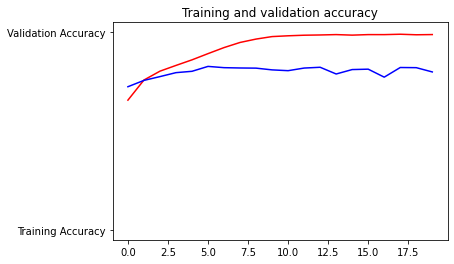

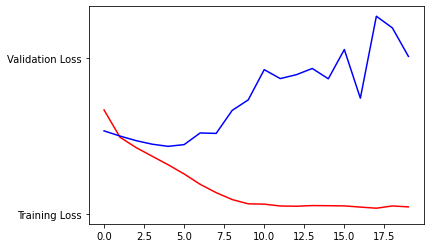

<Figure size 432x288 with 0 Axes>

In [6]:
#画出训练过程中的训练集和测试集的loss以及acc曲线（横坐标为epochs）
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()


plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


## 模型的预测使用

In [ ]:
# 没有测试集，所以只是一个简单的代码
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")